# 2 - Workflow management with atomate

In this lesson we cover a few more advanced features of the atomate software package.  More specifically we'll go over an example that includes parents and children, talk more about where you can find preset workflows, and cover a basic example of analyzing workflow-generated materials data.

## The elastic tensor: A multi-step preset workflow

In [7]:
from atomate.vasp.workflows.presets.core import wf_elastic_constant, wf_elastic_constant_minimal
from pymatgen import MPRester

In [2]:
mpr = MPRester()

In [3]:
structure = mpr.get_structure_by_material_id("mp-149", conventional_unit_cell=True)
# TODO: viewer here?
structure

Structure Summary
Lattice
    abc : 5.468727957193058 5.468727957193058 5.468727957193058
 angles : 90.0 90.0 90.0
 volume : 163.55316755397953
      A : 5.468727957193058 0.0 3.348630094092061e-16
      B : -3.348630094092061e-16 5.468727957193058 3.348630094092061e-16
      C : 0.0 0.0 5.468727957193058
PeriodicSite: Si (4.1015, 4.1015, 4.1015) [0.7500, 0.7500, 0.7500]
PeriodicSite: Si (2.7344, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: Si (4.1015, 1.3672, 1.3672) [0.7500, 0.2500, 0.2500]
PeriodicSite: Si (2.7344, 2.7344, 2.7344) [0.5000, 0.5000, 0.5000]
PeriodicSite: Si (1.3672, 4.1015, 1.3672) [0.2500, 0.7500, 0.2500]
PeriodicSite: Si (0.0000, 0.0000, 2.7344) [0.0000, 0.0000, 0.5000]
PeriodicSite: Si (1.3672, 1.3672, 4.1015) [0.2500, 0.2500, 0.7500]
PeriodicSite: Si (-0.0000, 2.7344, 0.0000) [0.0000, 0.5000, 0.0000]

In [10]:
wf = wf_elastic_constant_minimal(structure)

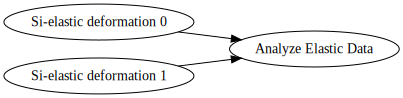

In [11]:
# TODO: plotter?
from mp_workshop.atomate import wf_to_graph
wf_to_graph(wf)

In [6]:
wf.links

{-26: [],
 -25: [-26],
 -24: [-26],
 -23: [-26],
 -22: [-26],
 -21: [-26],
 -20: [-26],
 -19: [-26],
 -18: [-26],
 -17: [-26],
 -16: [-26],
 -15: [-26],
 -14: [-26],
 -13: [-26],
 -12: [-26],
 -11: [-26],
 -10: [-26],
 -9: [-26],
 -8: [-26],
 -7: [-26],
 -6: [-26],
 -5: [-26],
 -4: [-26],
 -3: [-26],
 -2: [-26],
 -1: [-25,
  -24,
  -23,
  -22,
  -21,
  -20,
  -19,
  -18,
  -17,
  -16,
  -15,
  -14,
  -13,
  -12,
  -11,
  -10,
  -9,
  -8,
  -7,
  -6,
  -5,
  -4,
  -3,
  -2]}

From our exploration of the workflow, we can see that the workflow has a "root" firework, which is the structure optimization firework, and a single "leaf" firework, which is the analysis task.  In between, we have several fireworks which have "elastic deformation" in their titles, each of which represents a calculation which will transform the output of the optimization firework by applying a unique strain.

In the analysis step, the stresses from those deformations and the strains are aggregated and used to fit an elastic tensor.

To run the workflow, we import our launchpad and rocket launcher tools.  Since we can't use VASP in the workflow, we're also going to "fake" vasp by copying files rather than running the binary.

In [ ]:
from fireworks import LaunchPad
from atomate.vasp.powerups import use_fake_vasp

In [ ]:
# TODO: get this working
wf = use_fake_vasp(wf, ref_dirs="PUT_REF_DIRS_HERE")
lpad = LaunchPad()
lpad.reset('', require_password=False)
lpad.add_wf(wf)

In [ ]:
from fireworks.core.rocket_launcher import launch_rocket, rapidfire

In [ ]:
launch_rocket()

## Powerups

**TODO: I'm not sure this is all that useful, so it might go on the choppping block first**

Atomate contains a number of tools for modifying workflows, known as "powerups" which are functions which will modify the workflows in commonly desired ways.  For example, if you want to modify the parameters of a VASP calculation, you can use the add_modify_incar powerup to change these for every firework in the workflow.

In [ ]:
from atomate.vasp.powerups import add_modify_incar

In [ ]:
[task for task in wf.fws[0].tasks]

In [ ]:
modified = add_modify_incar(wf, {"incar_update": {"ENCUT": 700}})

In [ ]:
modified.fws[0].tasks

Prior to the execution of the VASP calculation, a ModifyIncar firetask is inserted which will read the incar and modify the ENCUT parameter such that it matches our powerup specification.

## A few other "complex" workflows.

Atomate contains a few workflows that will do more complicating things like calculations on surfaces.  Let's say I want to calculate the determine the hydrogen adsorption energy on every low-index facet of Pt.

In [ ]:
from atomate.vasp.workflows.base.adsorption import get_wf_surface_all_slabs
from pymatgen import MPRester, Molecule

In [ ]:
pt = mpr.get_structure_by_material_id("Pt", conventional_unit_cell=True)
adsorbate = Molecule("H", [[0, 0, 0]])

In [ ]:
wf = get_wf_surface_all_slabs(pt, [adsorbate])

In [ ]:
[fw.name for fw in wf.fws]

This is how you can do the requisite calculation to find the band-gap from an HSE calculation after the PBE bandstructure.

In [ ]:
from atomate.vasp.workflows.presets.core import wf_bandstructure_plus_hse

In [ ]:
wf = wf_bandstructure_plus_hse(structure)

In [ ]:
[fw.name for fw in wf.fws]

There's also support for workflows in FEFF and QChem.

In [ ]:
from atomate.feff.workflows.core import get_wf_xas

In [ ]:
wf = get_wf_xas("Si", structure)
[fw.name for fw in wf.fws]

In [ ]:
# TODO: double check that this will actually work
from atomate.qchem.workflows.base import double_FF_opt

## Analyzing workflow results

**TODO: flesh out description**, use stores?

Our final example for atomate will take a set of tasks from our database and construct a phase diagram

In [ ]:
chemsys = ["Li", "Fe", "P", "O"]

